# 버스 번호 추출 OCR모델 데모 버전
## 
### 첫번째 코드에 관련 주석 존재
### 전처리 코드는 주석 천천히 보시면 알 수 있을 거에요
### 현재 2112 ==> y112로 인식하는 문제가 있어 노이즈 제거한 뒤 다시 예측해볼 예정

License Plate #:  y112


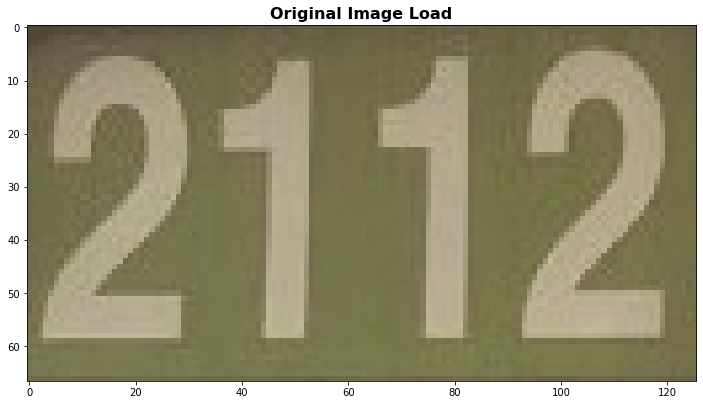

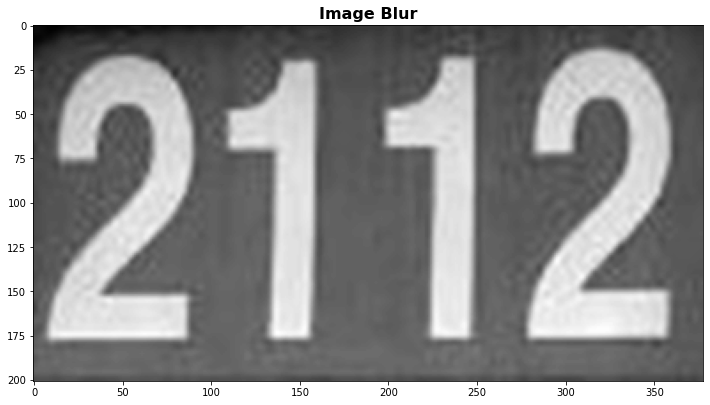

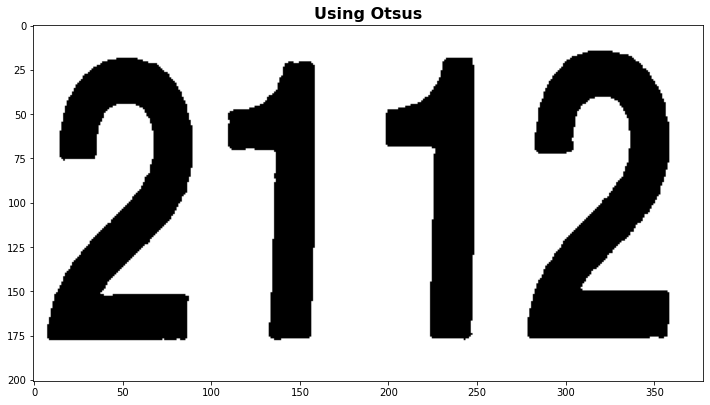

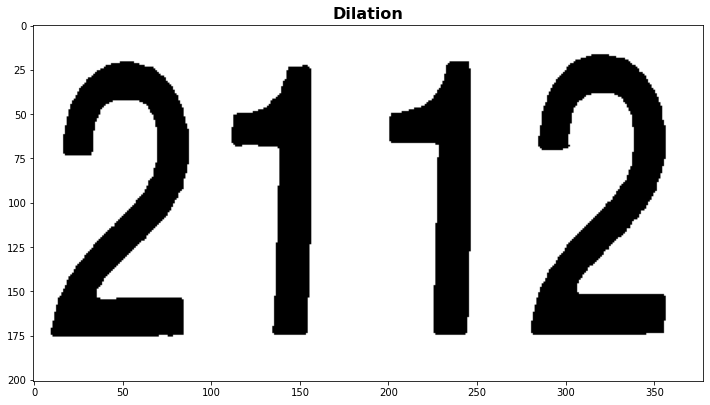

In [18]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pytesseract
import re
import math
import tensorflow as tf

## 사진 출력하는 코드, 코드 진행과 무관 ##
# plt.figure(figsize=(12, 10))
# plt.title('Original Image Load', fontdict={'fontsize': 16, 'fontweight': 'bold'})
# plt.imshow(box,cmap='gray')


## Original Image Load
box = cv2.imread('./Image/sample3.jpg')
plt.figure(figsize=(12, 10))
plt.title('Original Image Load', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.imshow(box,cmap='gray')

## 좌표 값 저장
# # separate coordinates from box
# xmin, ymin, xmax, ymax = coords

## Bounding Box Croping
# # get the subimage that makes up the bounded region and take an additional 5 pixels on each side
# box = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]

## 배경 Gray로 설정
# grayscale region within bounding box
gray = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)

## 이미지 사이즈 정규화(확대)
# resize image to three times as large as original for better readability
gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)

## 이미지 블러처리하기
# perform gaussian blur to smoothen image
blur = cv2.GaussianBlur(gray, (5,5), 0)
plt.figure(figsize=(12, 10))
plt.title('Image Blur', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.imshow(blur,cmap='gray')

## 이미지 흑백 대조하기, 최적 임계값을 자동으로 추출하는 Otsus 사용
# threshold the image using Otsus method to preprocess for tesseract
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.figure(figsize=(12, 10))
plt.title('Using Otsus', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.imshow(thresh,cmap='gray')

## 확장을 위한 커널 생성
# create rectangular kernel for dilation
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

## 글씨 이미지 크기 확장
# apply dilation to make regions more clear
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
plt.figure(figsize=(12, 10))
plt.title('Dilation', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.imshow(dilation,cmap='gray')

# find contours of regions of interest within license plate
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sort contours left-to-right
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# create copy of gray image
im2 = gray.copy()

# create blank string to hold license plate number
plate_num = ""

# loop through contours and find individual letters and numbers in license plate
for cnt in sorted_contours:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    # if height of box is not tall enough relative to total height then skip
    if height / float(h) > 6: continue

    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 1.5: continue

    # if width is not wide enough relative to total width then skip
    if width / float(w) > 15: continue

    area = h * w
    # if area is less than 100 pixels skip
    if area < 100: continue

    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    
    # grab character region of image
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    
    # perfrom bitwise not to flip image to black text on white background
    roi = cv2.bitwise_not(roi)

    # perform another blur on character region
    roi = cv2.medianBlur(roi, 5)
    
    try:
        text = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789 --psm 8 --oem 3')
        # clean tesseract text by removing any unwanted blank spaces
        clean_text = re.sub('[\W_]+', '', text)
        plate_num += clean_text
    except: 
        text = None
if plate_num != None:
    print("License Plate #: ", plate_num)
    

# 노이즈 제거 해보기

### bounding box가 just가 아니라 주변 검은 배경과 같이 잡혔을 경우:
### - 최적 임계값을 찾아주는 otsu가 제대로 작동하지 못함, 결과적으로 흑백 처리가 제대로 되지 않아 숫자 인식 불가

License Plate #:  


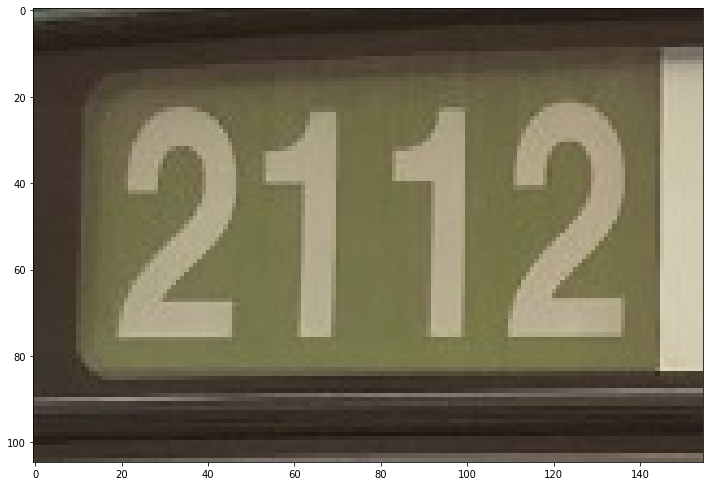

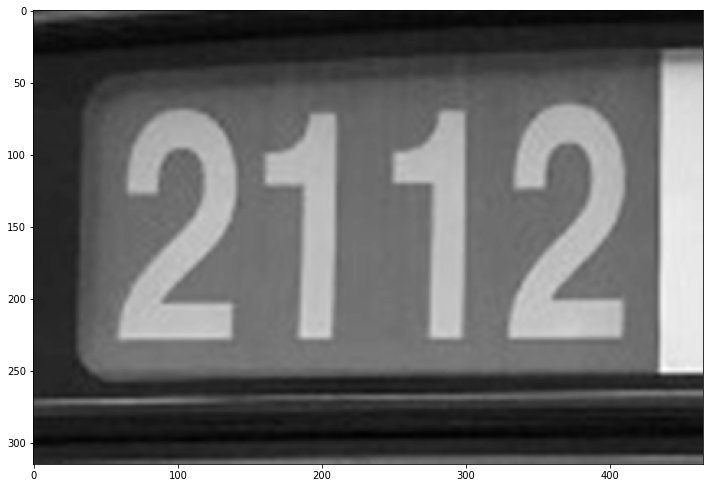

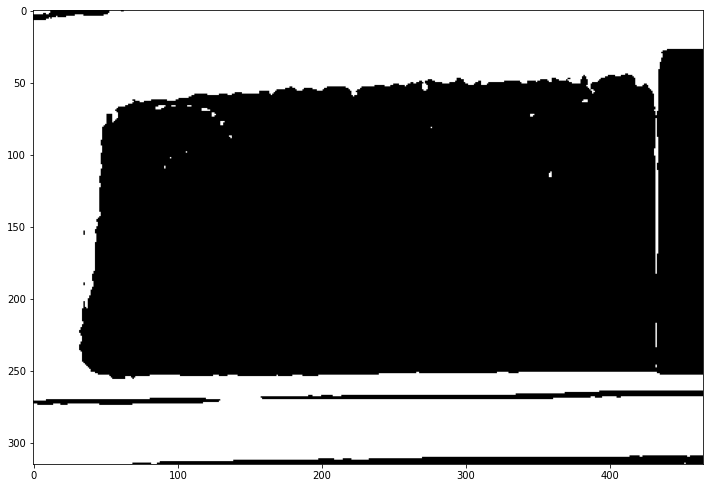

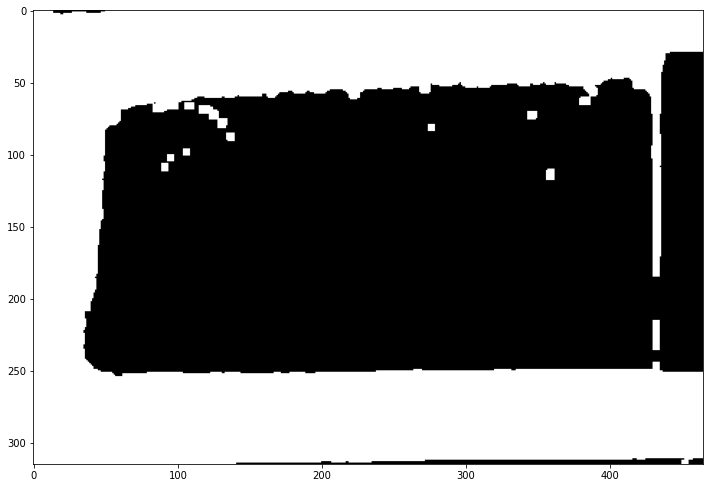

In [20]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pytesseract
import re
import math
import tensorflow as tf

box = cv2.imread('./Image/sample2.jpg')
plt.figure(figsize=(12, 10))
plt.imshow(box,cmap='gray')

# # separate coordinates from box
# xmin, ymin, xmax, ymax = coords
# # get the subimage that makes up the bounded region and take an additional 5 pixels on each side
# box = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]
# grayscale region within bounding box
gray = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
# plt.figure(figsize=(12, 10))
# plt.imshow(gray,cmap='gray')

# resize image to three times as large as original for better readability
gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
# plt.figure(figsize=(12, 10))
# plt.imshow(gray,cmap='gray')

# perform gaussian blur to smoothen image
blur = cv2.GaussianBlur(gray, (5,5), 0)
plt.figure(figsize=(12, 10))
plt.imshow(blur,cmap='gray')
#cv2.imshow("Gray", gray)
#cv2.waitKey(0)

# threshold the image using Otsus method to preprocess for tesseract
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.figure(figsize=(12, 10))
plt.imshow(thresh,cmap='gray')

#cv2.imshow("Otsu Threshold", thresh)
#cv2.waitKey(0)

# create rectangular kernel for dilation
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

# apply dilation to make regions more clear
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
plt.figure(figsize=(12, 10))
plt.imshow(dilation,cmap='gray')

#cv2.imshow("Dilation", dilation)
#cv2.waitKey(0)

# find contours of regions of interest within license plate
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sort contours left-to-right
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# create copy of gray image
im2 = gray.copy()

# create blank string to hold license plate number
plate_num = ""

# loop through contours and find individual letters and numbers in license plate
for cnt in sorted_contours:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    # if height of box is not tall enough relative to total height then skip
    if height / float(h) > 6: continue

    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 1.5: continue

    # if width is not wide enough relative to total width then skip
    if width / float(w) > 15: continue

    area = h * w
    # if area is less than 100 pixels skip
    if area < 100: continue

    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    # grab character region of image
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    # perfrom bitwise not to flip image to black text on white background
    roi = cv2.bitwise_not(roi)
    # perform another blur on character region
    roi = cv2.medianBlur(roi, 5)
    
    try:
        text = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789 --psm 8 --oem 3')
        # clean tesseract text by removing any unwanted blank spaces
        clean_text = re.sub('[\W_]+', '', text)
        plate_num += clean_text
    except: 
        text = None
if plate_num != None:
    print("License Plate #: ", plate_num)
#cv2.imshow("Character's Segmented", im2)
#cv2.waitKey(0)


### 노란색 차량 번호판의 경우 앞에 있는 한글까지 인식되나 한글 패치를 안해뒀기 때문에 '사'를 h로 인식

License Plate #:  h6211


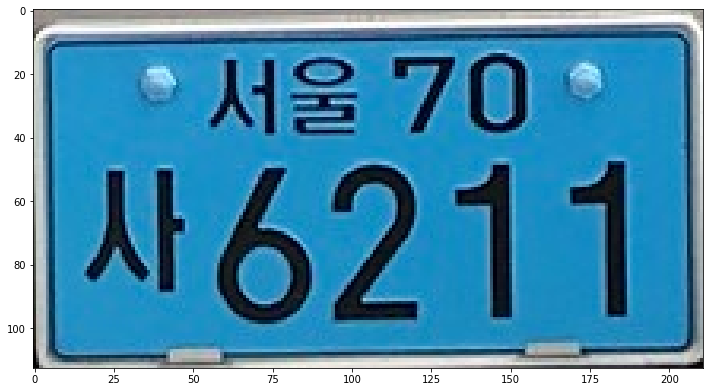

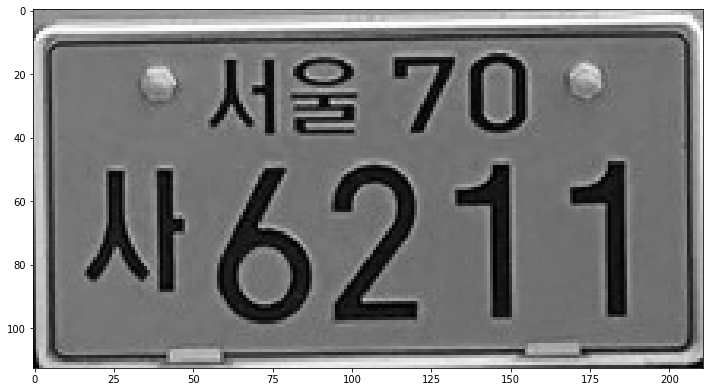

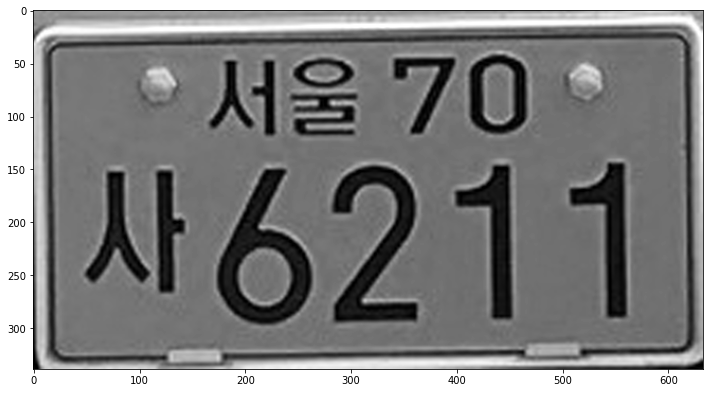

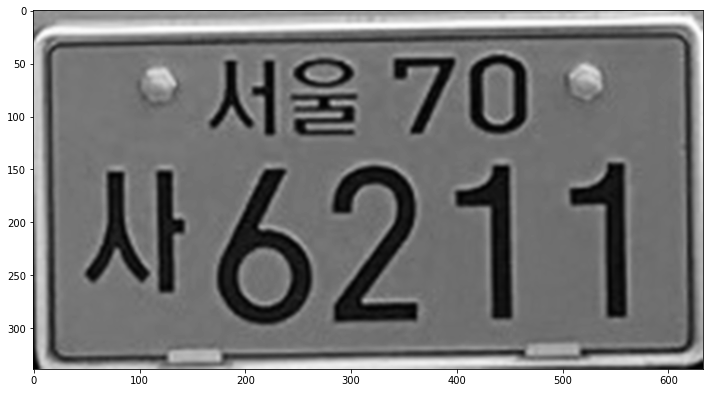

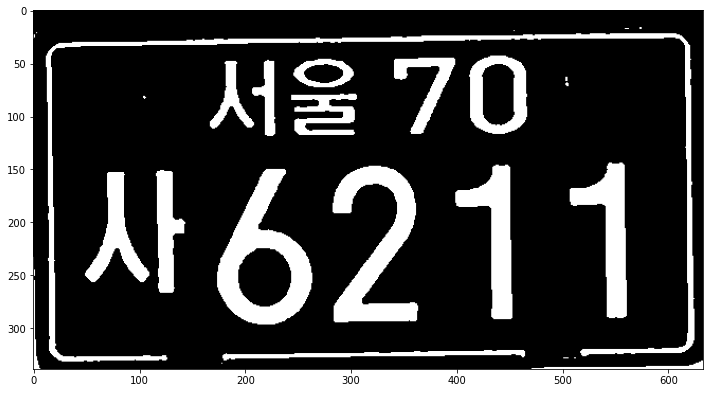

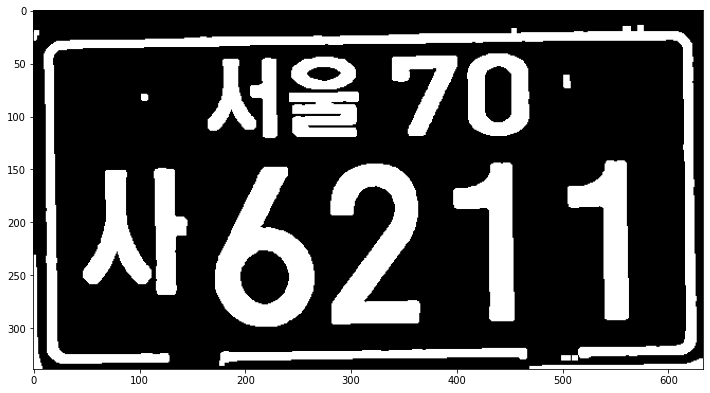

In [4]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pytesseract
import re
import math
import tensorflow as tf

box = cv2.imread('./Image/cut_img.png')
plt.figure(figsize=(12, 10))
plt.imshow(box,cmap='gray')

# # separate coordinates from box
# xmin, ymin, xmax, ymax = coords
# # get the subimage that makes up the bounded region and take an additional 5 pixels on each side
# box = img[int(ymin)-5:int(ymax)+5, int(xmin)-5:int(xmax)+5]
# grayscale region within bounding box
gray = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(12, 10))
plt.imshow(gray,cmap='gray')

# resize image to three times as large as original for better readability
gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
plt.figure(figsize=(12, 10))
plt.imshow(gray,cmap='gray')

# perform gaussian blur to smoothen image
blur = cv2.GaussianBlur(gray, (5,5), 0)
plt.figure(figsize=(12, 10))
plt.imshow(blur,cmap='gray')
#cv2.imshow("Gray", gray)
#cv2.waitKey(0)

# threshold the image using Otsus method to preprocess for tesseract
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.figure(figsize=(12, 10))
plt.imshow(thresh,cmap='gray')

#cv2.imshow("Otsu Threshold", thresh)
#cv2.waitKey(0)

# create rectangular kernel for dilation
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

# apply dilation to make regions more clear
dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
plt.figure(figsize=(12, 10))
plt.imshow(dilation,cmap='gray')

#cv2.imshow("Dilation", dilation)
#cv2.waitKey(0)

# find contours of regions of interest within license plate
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sort contours left-to-right
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# create copy of gray image
im2 = gray.copy()

# create blank string to hold license plate number
plate_num = ""

# loop through contours and find individual letters and numbers in license plate
for cnt in sorted_contours:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    # if height of box is not tall enough relative to total height then skip
    if height / float(h) > 6: continue

    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 1.5: continue

    # if width is not wide enough relative to total width then skip
    if width / float(w) > 15: continue

    area = h * w
    # if area is less than 100 pixels skip
    if area < 100: continue

    # draw the rectangle
    rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
    # grab character region of image
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    # perfrom bitwise not to flip image to black text on white background
    roi = cv2.bitwise_not(roi)
    # perform another blur on character region
    roi = cv2.medianBlur(roi, 5)
    
    try:
        text = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3')
        # clean tesseract text by removing any unwanted blank spaces
        clean_text = re.sub('[\W_]+', '', text)
        plate_num += clean_text
    except: 
        text = None
if plate_num != None:
    print("License Plate #: ", plate_num)
#cv2.imshow("Character's Segmented", im2)
#cv2.waitKey(0)
